# General equilibrium


## Consumption & labor supply


---

### Household problem (representative household)

- Household problem:

  $$
  \begin{aligned}
  \max_{c,~ h} \enskip&
    \left\{\frac{c^{1-\gamma} - 1}{1-\gamma} - \psi \frac{h^{1+1/\theta}}{1+1/\theta} \right\}\\
    \text{subject to} \quad  c &= r \cdot a + w\cdot h \\
        c &\geq 0\;, h \geq 0
  \end{aligned}
  $$

- Choice variables:

  - $c$: Consumption
  - $h$: Hours worked

- Parameters:

  - $\gamma$: Relative risk aversion
  - $\psi$: Weight on disutility of work
  - $\theta$: Labor supply elasticity
  - $a$: Initial assets

- Prices (taken as given, competitive equilibrium):

  - $r$: Interest rate (return on capital)
  - $w$: Wage rate


---

### Firm problem (representative firm)

- Firm problem:

  $$
  \max_{K,~L} \enskip \Pi =
      \underbrace{z K^{\alpha} L^{1-\alpha}}_{\text{Output } Y}
       - \underbrace{r K}_{\text{Cost of capital}}
       - \underbrace{w L}_{\text{Cost of labor}}
  $$

- Choice variables:

  - $K$: Capital
  - $L$: Labor

- Parameters:

  - $\alpha$: Capital share (or elasticity with respect to capital)
  - $z$: Total factor productivity (TFP)

- Prices (taken as given, competitive equilibrium):

  - $r$: Return on capital
  - $w$: Wage rate

- First-order conditions:

  $$
  \begin{aligned}
  r &= \alpha z \left(\frac{K}{L}\right)^{\alpha-1} = \alpha z k^{\alpha-1} \\
  w &= (1-\alpha) z\left(\frac{K}{L}\right)^{\alpha} = (1-\alpha) z k^{\alpha}
  \end{aligned}
  $$

  where $k \equiv \frac{K}{L}$ is the capital-labor ratio.

- Labor demand:
  <a id='ls-firm-L'></a>
  $$
  L = \left( \frac{w}{(1-\alpha) z} \right)^{-\frac{1}{\alpha}}K
      \tag{1.1}
  $$


---

### Equilibrium

Quantities $(K,L,Y,c,h)$ and prices $(r,w)$ such that:

- Asset market: $K = a$ (capital $a$ supplied by households equals capital $K$ demanded by firms).
- Labor market: $L = h$ (hours $h$ supplied by households equals labor $L$ demanded by firms).
- Goods market: $Y = c$ (the amount of goods $c$ consumed by households equals aggregate output).


---

### Analytical solution

- This problem is simple enough to be solved analytically:
  $$
  h = L = \left[ \frac{(1-\alpha)\left(z a^{\alpha}\right)^{1-\gamma}}{\psi}
      \right]^{\frac{1}{1/\theta + \alpha + \gamma - \alpha \gamma}}
  $$


---

### Numerical solution

- General rule: solve as much as possible analytically (we ignore this here)

- **Firm problem:** use first-order conditions

- **Household problem:** usually solved via minimizer (or other methods)

- **Equilibrium:** usually solved via root-finder (zero excess demand)


#### Solution algorithm

1.  Define parameters.

2.  Function to solve the household problem for given $(w, r)$ which returns
    the **optimal labor supply $h$\*** (use a minimizer).

3.  Function to solve the firm problem for given $w$ which returns the **firm labor demand $L$**
    (use the firm's first-order conditions).

4.  Function $f(w)$ which returns the **excess labor demand** for a given $w$, defined
    as $L - h$.

    Use the functions from steps (1) and (2) to compute $h$ and $L$.

5.  Make an initial guess for the equilibrium wage rate $w_0$ and call the root-finder
    to locate the root $w^*$ of $f$, $f(w^*) = 0$.

6.  Compute and store all other equilibrium quantities and prices for given $w^*$.


#### Implementation

- See [lecture06_labor.py](lecture06_labor.py) for full implementation


In [2]:
# Enable automatic reloading of external modules
%load_ext autoreload
%autoreload 2

##### Step 1: Define parameters


- Recall how we used to define functions with each parameter as separate argument
- This becomes tedious as the number of parameters grows
- Replace with single `Parameters` class


In [21]:
# Data Class
from dataclasses import dataclass


@dataclass
class Parameters:
    """
    Container to store problem parameters
    """

    alpha: float = 0.36  # Capital share in firm output
    z: float = 1.0  # Total factor productivity (TFP) in production function
    gamma: float = 2.0  # Relative Risk aversion coefficient
    psi: float = 1.0  # Weight on disutility of labor
    theta: float = 0.5  # Frisch elasticity of labor supply
    a: float = 5.0  # Assets given to households in the initial period

In [22]:
# Create an instance of the parameter class
par = Parameters()
print(par)
par = Parameters(alpha=0.33)
print(par)

Parameters(alpha=0.36, z=1.0, gamma=2.0, psi=1.0, theta=0.5, a=5.0)
Parameters(alpha=0.33, z=1.0, gamma=2.0, psi=1.0, theta=0.5, a=5.0)


In [23]:
import numpy as np


par = Parameters()


def util(c, h, par: Parameters):
    # Consumption utility
    if par.gamma == 1:
        # Log utility
        u = np.log(c)
    else:
        # General CRRA utility
        u = (c ** (1 - par.gamma) - 1) / (1 - par.gamma)
    # add disutility of labor
    u -= par.psi * h ** (1 + 1 / par.theta) / (1 + 1 / par.theta)
    return u

In [24]:
util(0.5, 0.5, par)

-1.0416666666666667

<div class="alert alert-info">
<h3> Your turn</h3>

Rewrite the <TT>util()</TT> function from above so that it accepts a single <TT>par</TT> argument
of type <TT>Parameters</TT> instead of individual <TT>gamma</TT>, <TT>psi</TT>, and <TT>theta</TT>.

</div>


##### Step 2: Solving the household problem


- Use [L-BFGS-B minimizer](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html)
  from
  `scipy.optmize` module.
- Minimize over choice variable $h$
- Need to specify bounds $h \geq 0$


In [26]:
from scipy.optimize import minimize


def solve_hh(r, w, par: Parameters):
    """
    Solve household problem for given prices and parameters

    Parameters
    ----------
    r : float
        Return on capital
    w : float
        Wage rate
    par : Parameters
        Parameters for given problem

    Returns
    -------
    c_opt : float
        Optimal consumption choice
    h_opt : float
        Optimal hours choice
    """
    # Initial guess for h
    h_guess = 0.5

    # Run minimizer to find optimal hours:
    # The budget constraint is inserted directly in the lambda expression.
    res = minimize(
        lambda h: -util(r * par.a + w * h, h, par),
        x0=h_guess,
        method="L-BFGS-B",
        bounds=((0, None),),  # h >= 0
    )

    if not res.success:
        print("Minimizer did not terminate successfully")
        print(res.message)
        print(f"  Prices: {r}, {w}")

    # Recover optimal hours choice
    h_opt = res.x[0]
    # Optimal consumption follows from budget constraint
    c_opt = r * par.a + w * h_opt

    return c_opt, h_opt

In [37]:
print(solve_hh(r=0.1, w=1.0, par=Parameters(gamma=1)))  # Changing gamma
print(solve_hh(r=0.1, w=1.0, par=par))  # Using default parameters

(np.float64(1.3580933653386205), np.float64(0.8580933653386204))
(np.float64(1.2807763689512406), np.float64(0.7807763689512405))


<div class="alert alert-info">
<h3> Your turn</h3>

Plot the optimal hours <i>h</i> returned by <tt>solve_hh()</tt>
for <tt>w</tt> on the interval [0.5, 2]. Fix the interest rate at <i>r=0.1</i> for this exercise. Does the shape intuitively make sense?

</div>


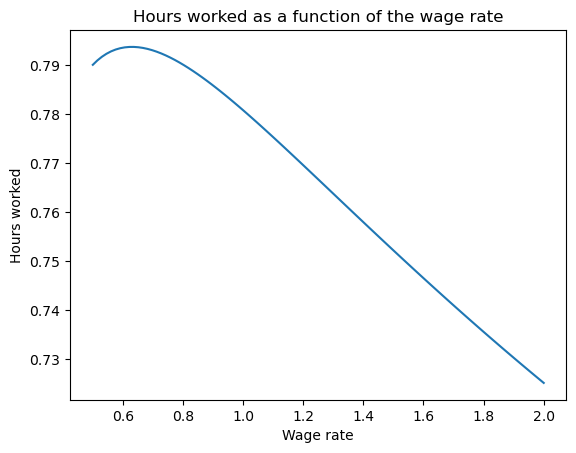

In [46]:
# Create a grid of wage rates
w_grid = np.linspace(0.5, 2.0, 100)

# Plot the optimal hours h as a function of the wage rate w with r = 0.1
import matplotlib.pyplot as plt

h_opt = np.zeros_like(w_grid)
# np.empty_like creates an empty array with the same shape as w_grid
# Could also use np.zeros_like

for i, w in enumerate(w_grid):
    c_opt, h_opt[i] = solve_hh(r=0.1, w=w, par=par)

plt.plot(w_grid, h_opt)
plt.xlabel("Wage rate")
plt.ylabel("Hours worked")
plt.title("Hours worked as a function of the wage rate")
plt.show()

Text(0.5, 1.0, 'Hours worked as a function of the wage rate')

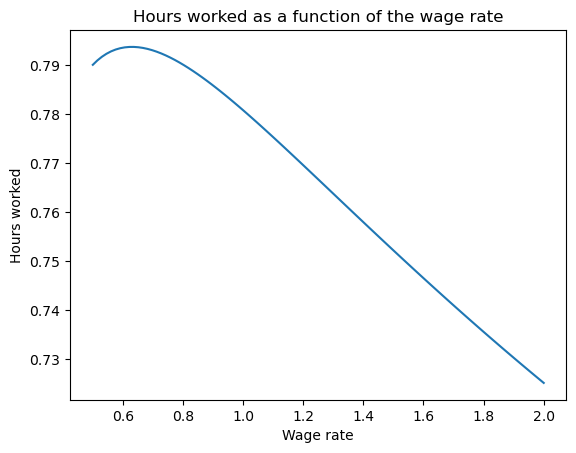

In [47]:
# Create a grid of wage rates
w_grid = np.linspace(0.5, 2.0, 100)

h_grid = [solve_hh(r=0.1, w=w, par=par)[1] for w in w_grid]

plt.plot(w_grid, h_grid)
plt.xlabel("Wage rate")
plt.ylabel("Hours worked")
plt.title("Hours worked as a function of the wage rate")

##### Step 2: Solving the firm problem

- Compute firm labor demand from [(1.1)](#ls-firm-L):
  $$
  L = \left( \frac{w}{(1-\alpha) z} \right)^{-\frac{1}{\alpha}}K
      \tag{1.1}
  $$
- Addionally return output $Y$ and interest rate $r$ for later use


In [49]:
def solve_firm(w, par: Parameters):
    """
    Return the solution to the firm's problem for given wage rate and parameters.

    Parameters
    ----------
    w : float
        Wage rate
    par : Parameters
        Parameters for given problem

    Returns
    -------
    L : float
        Firm labor demand
    Y : float
        Firm output
    r : float
        Interest rate implied by wage rate

    """
    # Capital market clearing condition
    K = par.a

    # Labor demand implied by firm FOC
    L = (w / (1 - par.alpha) / par.z) ** (-1 / par.alpha) * K

    # Optimal capital-labor ratio
    k = K / L

    # Return on capital
    r = par.z * par.alpha * k ** (par.alpha - 1)

    # Output for Cobb-Douglas production function
    Y = par.z * K**par.alpha * L ** (1 - par.alpha)

    return L, Y, r

<div class="alert alert-info">
<h3> Your turn</h3>

Plot the firm's optimal labor demand <i>L</i> returned by <tt>solve_firm()</tt>
for <tt>w</tt> on the interval [0.5, 2]. Does the shape intuitively make sense?

</div>


Text(0.5, 1.0, 'Labor demand as a function of the wage rate')

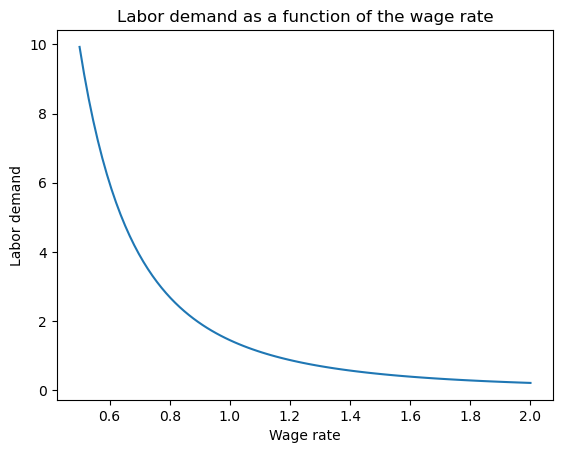

In [50]:
# wage grid
w_grid = np.linspace(0.5, 2.0, 100)

# L grid
L_grid = [solve_firm(w, par)[0] for w in w_grid]

# Plot
plt.plot(w_grid, L_grid)
plt.xlabel("Wage rate")
plt.ylabel("Labor demand")
plt.title("Labor demand as a function of the wage rate")

##### Step 3: Compute excess demand for labor


In [51]:
def compute_labor_ex_demand(w, par: Parameters):
    """
    Compute excess labor demand for given wage rate and parameters.

    Parameters
    ----------
    w : float
        Wage rate
    par : Parameters
        Parameters for given problem

    Returns
    -------
    ex_demand : float
        Excess labor demand (firm demand - household supply)
    """
    # Solve firm problem for given wage rate
    L, Y, r = solve_firm(w, par)

    # Optimal household choices for given prices
    c_opt, h_opt = solve_hh(r, w, par)

    # Excess demand for labor
    ex_demand = L - h_opt

    return ex_demand

<div class="alert alert-info">
<h3> Your turn</h3>

Before running the root-finder, we want to visually verify that the excess demand for
labor is indeed zero for some <tt>w</tt>.

Using the code we just wrote, plot the function <tt>compute_capital_ex_labor()</tt>
for <tt>w</tt> on the interval [0.5, 2].

</div>


In [52]:
ex_demand = [compute_labor_ex_demand(w, par) for w in w_grid]

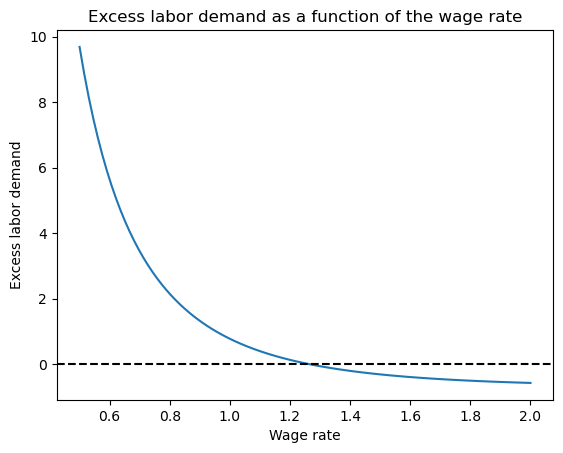

In [53]:
# Plot
plt.plot(w_grid, ex_demand)
plt.xlabel("Wage rate")
plt.ylabel("Excess labor demand")
plt.title("Excess labor demand as a function of the wage rate")
plt.axhline(0, color="black", linestyle="--")

##### Step 4: Call root-finder to find equilibrium

- Use
  [`root_scalar()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root_scalar.html)
- Use `method='newton'` and specify initial value `x0`


In [61]:
from scipy.optimize import root_scalar

# Intial guess for wage rate
w0 = 1.0

res = root_scalar(compute_labor_ex_demand, x0=w0, method="newton", args=(par,))

In [60]:
res

      converged: True
           flag: converged
 function_calls: 18
     iterations: 9
           root: 1.2643421155116474
         method: newton

##### Step 5: Compute remaining equilibrium quantities

- Use `Equilibrium` definition to store quantities and prices
- Compute equilibrium using `compute_equilibrium()` from [`lecture06_labor`](lecture06_labor.py) module
- Print equilibrium using `print_equilibrium()` from [`lecture06_labor`](lecture06_labor.py) module


In [62]:
@dataclass
class Equilibrium:
    """
    Container to store equilibrium allocations and prices.
    """

    par: Parameters = None  # Parameters used to compute equilibrium
    c: float = None  # Optimal consumption
    h: float = None  # Optimal hours
    r: float = None  # Interest rate
    w: float = None  # Wage rate
    L: float = None  # Labor demand
    K: float = None  # Capital demand
    Y: float = None  # Output

In [65]:
# Import helper functions from module
from lecture06_labor import compute_equilibrium, print_equilibrium

# Compute equilibrium, return Equilibrium object
eq = compute_equilibrium(par)

# Print equilibrium allocation and prices
print_equilibrium(eq)

Equilibrium:
  Households:
    c = 1.49042
    h = 0.75444
  Firms:
    Y = 1.49042
    L = 0.75444
    K = 5.00000
  Prices:
    r = 0.10731
    w = 1.26434
  Market clearing:
    Labor market: -4.90011e-10
    Goods market: 6.19542e-10


---

### Comparative statics

#### Compute equilibrium for different parameter values

- How do equilibrium prices & quantities depend on $a$?


<div class="alert alert-info">
<h3> Your turn</h3>

<ol>
    <li>Use the function <TT>compute_equilibrium()</TT> to evaluate the equilibria for N=30 different
values of <i>a</i> on the interval [1, 10].</li>
    <li>How can you check that the algorithm returned something sensible for all <i>a</i>?</li>
</ol>

</div>


In [87]:
# Solve for 30 equilibria with uniformly spaced values for a
N = 30
a_grid = np.linspace(1.0, 10.0, N)

# Initialize list to store equilibrium objects
equilibria = [compute_equilibrium(par=Parameters(a=a)) for a in a_grid]

In [88]:
# Print max. absolute error in labor market clearing
max(abs(eq.L - eq.h) for eq in equilibria)

np.float64(1.0116618875954941e-08)

In [89]:
# Print max. absolute error in goods market clearing
max(abs(eq.c - eq.Y) for eq in equilibria)

np.float64(1.5103167161356623e-08)

#### Plot equilibrium quantities and prices


In [90]:
# Convert equilibrium data to arrays
c_eq_grid = np.array([eq.c for eq in equilibria])
h_eq_grid = np.array([eq.h for eq in equilibria])
w_eq_grid = np.array([eq.w for eq in equilibria])
r_eq_grid = np.array([eq.r for eq in equilibria])

Text(0.5, 1.0, 'Equil. labor supply $h$')

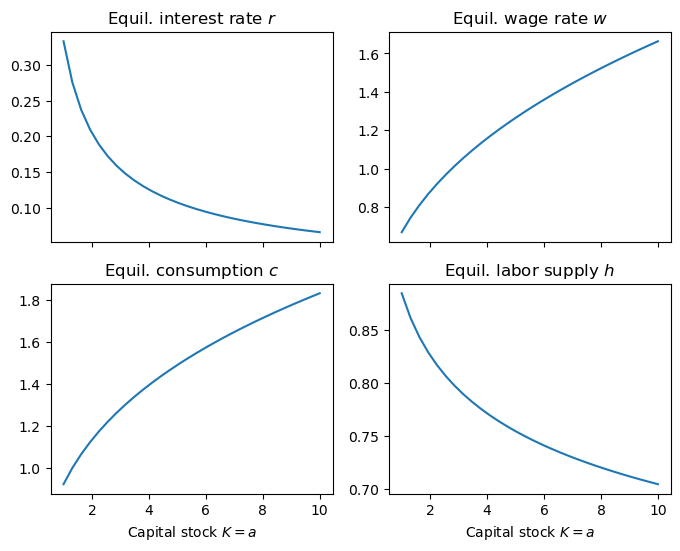

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True)

ax[0, 0].plot(a_grid, r_eq_grid)
ax[0, 0].set_title("Equil. interest rate $r$")

ax[0, 1].plot(a_grid, w_eq_grid)
ax[0, 1].set_title("Equil. wage rate $w$")

ax[1, 0].plot(a_grid, c_eq_grid)
ax[1, 0].set_xlabel("Capital stock $K = a$")
ax[1, 0].set_title("Equil. consumption $c$")

ax[1, 1].plot(a_grid, h_eq_grid)
ax[1, 1].set_xlabel("Capital stock $K = a$")
ax[1, 1].set_title("Equil. labor supply $h$")

---

## Overlapping-generations model


### Household problem

- Household problem (assume $N$ identical households):

  $$
  \begin{aligned}
  \max_{c_y,~c_o,~a} \enskip & \Bigl\{ u(c_y) + \beta u(c_o) \Bigr\} \\
  \text{s.t.} \quad c_y + a &= w \\
                  c_o &= (1+r)a \\
      c_y &\geq 0, ~ c_o \geq 0,~ a \geq 0
  \end{aligned}
  $$

- Flow utility:

  $$
  u(c) = \begin{cases}
      \frac{c^{1-\gamma}}{1-\gamma} & \text{if } \gamma \neq 1 \\
      \log(c) & \text{if } \gamma = 1
      \end{cases}
  $$

- Choice variables:

  - $c_y$: Consumption when young
  - $c_o$: Consumption when old
  - $a$: Savings when young

- Parameters:

  - $\beta$: Discount factor
  - $\gamma$: Relative risk aversion
  - Each household inelastically supplies 1 unit of labor when young (h = 1)

- Prices (taken as given, competitive equilibrium):

  - $r$: Interest rate (return on capital)
  - $w$: Wage rate


---

### Firm problem (representative firm) — same as above

- Firm problem:

  $$
  \max_{K,~L} \enskip \Pi =
      \underbrace{z K^{\alpha} L^{1-\alpha}}_{\text{Output } Y}
       - \underbrace{r K}_{\text{Cost of capital}}
       - \underbrace{w L}_{\text{Cost of labor}}
  $$

- Choice variables:

  - $K$: Capital
  - $L$: Labor

- Parameters:

  - $\alpha$: Capital share (or elasticity with respect to capital)
  - $z$: Total factor productivity (TFP)

- Prices (taken as given, competitive equilibrium):

  - $r$: Return on capital
  - $w$: Wage rate

- First-order conditions:
  $$
  \begin{aligned}
  r &= \alpha z \left(\frac{K}{L}\right)^{\alpha-1} = \alpha z k^{\alpha-1} \\
  w &= (1-\alpha) z\left(\frac{K}{L}\right)^{\alpha} = (1-\alpha) z k^{\alpha}
  \end{aligned}
  $$
  where $k \equiv \frac{K}{L}$ is the capital-labor ratio.


---

### Equilibrium

Set of quantities $(K,L,Y,c_o,c_y,a)$ and prices $(r,w)$ such that:

- Asset market: $K = N a$ (aggregate savings $N a$ supplied by households equal capital $K$ demanded by firms).
- Labor market: $L = N$ (Labor $L$ demanded by firms equals exogenously supplied labor by households).
- Goods market: $Y = N(c_y + c_o)$ (the amount of goods consumed by young and old each period equals aggregate output).


---

### Analytical solution

- Households:
  - Optimal **savings rate** of the young:
    <a id='olg-hh-srate'></a>
    $$
    \tag{2.2}
    s = \frac{1}{1 + \beta^{-\frac{1}{\gamma}} (1+r)^{1-\frac{1}{\gamma}}}
    $$
  - Optimal **savings** of the young:
    $$
    a = s \cdot w
    $$


---

### Numerical solution


#### Solution algorithm

1. Define parameters

2. Function to compute **prices** $(r,w)$ for a given $k$
   (use firm's first-order conditions [(2.1)](#olg-firm-prices)).

3. Function to solve the household problem for given $r$ and return
   the **savings rate $s$** (use analytical solution [(2.2)](#olg-hh-srate))

4. Function $f(k)$ to compute **excess demand for capital** $K - Na$
   for given $k$.

   Use the functions defined in steps (1) and (2) for this purpose.

5. Call a root-finder to locate the root $k^*$ of $f$, $f(k^*) = 0$

6. Compute and store all other equilibrium quantities and prices given equilibrium $k^*$.


#### Implementation

- See [`lecture06_olg.py`](lecture06_olg.py) for full implementation


##### Step 1: Define parameters


In [ ]:
from dataclasses import dataclass


@dataclass
class Parameters:
    """













    Parameters for the overlapping generations model.
    """

    alpha: float = 0.36  # Capital share in production function

    z: float = 1.0  # TFP

    beta: float = 0.96  # Discount factor

    gamma: float = 2.0  # RRA in utility

    N: int = 1  # Number of households per cohort

In [ ]:
# Create parameter instance
par = Parameters()

##### Step 2: Compute equilibrium prices from $k$


In [ ]:
def compute_prices(k, par: Parameters):
    """
    Return the solution to the firm's problem for given return on capital
    and parameters.

    Parameters
    ----------
    k : float
        Capital-labor ratio
    par : Parameters
        Parameters for the given problem

    Returns
    -------
    r : float
        Return on capital
    w : float
        Wage rate

    """

##### Step 3: Solve the household problem


In [ ]:
def compute_savings_rate(r, par: Parameters):
    """
    Compute the savings rate using the analytical solution
    to the household problem.

    Parameters
    ----------
    r : float
        Return on capital
    par : Parameters
        Parameters for the given problem

    Returns
    -------
    s : float
        Savings rate
    """

<div class="alert alert-info">
<h3> Your turn</h3>

Plot the households's optimal savings rate <i>s</i> returned by <tt>compute_savings_rate()</tt>
for <tt>r</tt> on the interval [0.01, 0.2]. Does the shape intuitively make sense (given the parameter for the risk aversion γ)?

</div>


##### Step 4: Compute excess capital demand


In [ ]:
def compute_capital_ex_demand(k, par: Parameters):
    """
    Compute the excess demand for capital.

    Parameters
    ----------
    k : float
        Capital-labor ratio
    par : Parameters
        Parameters for the given problem

    Returns
    -------
    ex_demand : float
        Excess demand for capital
    """

<div class="alert alert-info">
<h3> Your turn</h3>

Using the code we just wrote, plot the function <tt>compute_capital_ex_demand()</tt> for 50 points of
<tt>k</tt> which are uniformly spaced on the interval [0.01, 1].

</div>


##### Step 5: Call the root-finder

- Use
  [`root_scalar()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root_scalar.html)
- Use `method='brentq'` (the default) and specify initial bracket


##### Step 5: Compute remaining equilibrium quantities


- Compute equilibrium using `compute_olg_equilibrium()` from [`lecture06_olg`](lecture06_olg.py) module
- Print equilibrium using `print_olg_equilibrium()` from [`lecture06_olg`](lecture06_olg.py) module


In [ ]:
from lecture06_olg import compute_olg_equilibrium, print_olg_equilibrium

# Compute equilibrium, return OLGEquilbrium instance
eq = compute_olg_equilibrium(par)

# Print equilibrium allocation & prices
print_olg_equilibrium(eq)

<div class="alert alert-info">
<h3> Your turn</h3>

You are interested in how the equilibrium prices depend on the cohort size <i>N</i>. Plot the equilibrium prices <i>r</i> and <i>w</i> when varying <i>N</i> over the range of integers from 1 to 10.

</div>
